# 1 Import and Init

In [5]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np 
import pandas as pd 
import random as rd
import torch
from transformers import BertTokenizer, BertModel

In [9]:
# fixer les graines de générateurs de nombres aléatoires afin d'avoir des résultats reproductibles
seed=1996
np.random.seed(seed)
rd.seed(seed)

In [10]:
work_dir="/home/onyxia/work"
data_filename="Test_word_embedding.csv"
firstname="firstname_with_sex.csv"
transcriptions="transcriptions_with_sex.csv"
# modéle
n_max_token=12

# 2 Loaded and preprocessing data

In [65]:
#df=pd.read_csv(data_filename)
FN_df=pd.read_csv(firstname,sep=";")
Trs_df=pd.read_csv(transcriptions)

In [13]:
Trs_df.head(3)

,subject_line,groundtruth,prediction,sex
0,ebb26ada-044c-4c62-9dbc-a9c8d505d31c,surname: Chardon firstname: Marie occupation: ...,nom: Chardon prénom: Marie date_naissance: 30 ...,femme
1,338496f5-e4ca-43ac-aa5c-429cb3f6ac00,surname: Lhopital firstname: Louis-Jean occupa...,nom: Lhopital prénom: Louis Jean date_naissanc...,homme
2,e6a279da-9b6f-4f49-b498-64857bc50d1e,surname: Papin firstname: Marie occupation: id...,nom: Pyrin prénom: Marie date_naissance: 55 re...,femme


In [14]:
# fonction pour transformer en minuscule les chaînes d ecaractéres et supprimers les accents

In [16]:
from unidecode import unidecode
def str_lower(string):
# Convertir en minuscules et supprimer les accents
     chaine_traitee = unidecode(string.lower())
     return chaine_traitee



In [ ]:
# Transformation en minuscule des noms et suppression des accent
FN_df.firstname=FN_df.firstname.apply(lambda x: str_lower(x))

## 2.1 firstname_with_sex

In [17]:
FN_df.head(2)

,firstname,male,female
0,marie,10145,2390322
1,jean,1869615,6476


In [68]:
# definition de la variable Male_name_fred qui represente pour chaque,la part d'homme d'homme le portant
FN_df["Male_name_fred"]=FN_df["male"]/(FN_df["male"]+FN_df["female"])

In [19]:
FN_df.head(3)

,firstname,male,female,Male_name_fred
0,marie,10145,2390322,0.004226
1,jean,1869615,6476,0.996548
2,pierre,1475841,5047,0.996592


In [69]:
# recupérer et stock les noms et frequences associées
Probas=FN_df["Male_name_fred"].values
Names=FN_df["firstname"].values

In [70]:
Probas[0:5]

array([0.00422626, 0.99654814, 0.99659191, 0.00160577, 0.9945651 ])

In [46]:
Names[0:5]

array(['marie', 'jean', 'pierre', 'jeanne', 'francois'], dtype=object)

## 2.2 Preprocessing on transcriptions_with_sex

In [71]:
# suppression de la colonne subject_line qui n'a aucun n'intéret pour l"tude finale
columns=Trs_df.columns
columns

Index(['subject_line', 'groundtruth', 'prediction', 'sex'], dtype='object')

In [72]:
Trs_df=Trs_df.drop(['subject_line'],axis=1)

In [73]:
# Transformation en minuscule des noms et suppression des accent
Trs_df.groundtruth=Trs_df.groundtruth.apply(lambda x: str_lower(x))
Trs_df.prediction=Trs_df.prediction.apply(lambda x: str_lower(x))

In [27]:
# Suppression de caractéres speciaux

In [74]:
Trs_df.prediction.values[0],Trs_df.prediction.values[2]

('nom: chardon prenom: marie date_naissance: 30 lieux_naissance: " ',
 'nom: pyrin prenom: marie date_naissance: 55 relation: d ')

In [75]:
# Caractères spéciaux à supprimer
special_chars = ['"', "''", '°', ';', '\\', '(', ')']

# Définir une fonction pour supprimer les caractères spéciaux
def remove_special_chars(chaine):
    for char in special_chars:
        chaine = chaine.replace(char, '')
    return chaine

# Appliquer la fonction à chaque élément du DataFrame
Trs_df = Trs_df.applymap(remove_special_chars)


In [76]:
Trs_df.head(3)

,groundtruth,prediction,sex
0,surname: chardon firstname: marie occupation: ...,nom: chardon prenom: marie date_naissance: 30 ...,femme
1,surname: lhopital firstname: louis-jean occupa...,nom: lhopital prenom: louis jean date_naissanc...,homme
2,surname: papin firstname: marie occupation: id...,nom: pyrin prenom: marie date_naissance: 55 re...,femme


In [1346]:
Trs_df.groundtruth.values[1:5]

array(['surname: lhopital firstname: louis-jean occupation: sp link: chef age: 67 ',
       'surname: papin firstname: marie occupation: idem link: idem employer: idem age: 15 ',
       'surname: lavocat firstname: marie link: femme birth_date: 1875 lob: rigny ',
       'surname: benne firstname: marguerite age: 78 '], dtype=object)

In [1347]:
Trs_df.prediction.values[1:5]

array(['nom: lhopital prenom: louis jean date_naissance: 67 lieux_naissance: sn employeur: ahef ',
       'nom: pyrin prenom: marie date_naissance: 55 relation: d ',
       'nom: lavocat prenom: marie date_naissance: 1875 lieux_naissance: rigny profession:  ',
       'nom: benne prenom: marguerite date_naissance: 78 lieux_naissance: id relation:  '],
      dtype=object)

In [77]:
# Ne gardez que les colonnes intéressantes pour l'étude
df_w=Trs_df.copy()
cols_to_drop=[ 'groundtruth']
df_w=df_w.drop(cols_to_drop,axis=1)
df_w.head(2)

,prediction,sex
0,nom: chardon prenom: marie date_naissance: 30 ...,femme
1,nom: lhopital prenom: louis jean date_naissanc...,homme


In [78]:
import re

def ajouter_virgule_avant_mots_specifiques(phrase):
    # Liste des mots spécifiques à trouver
    mots_specifiques = ['prenom', 'date_naissance', 'lieux_naissance', 'relation', 'employeur',"profession"]
    # Expression régulière pour trouver les mots spécifiques suivis de deux-points
    regex = r'(' + '|'.join(mots_specifiques) + r')\s*:'
    # Remplacez chaque occurrence de la regex par une virgule suivie du mot spécifique
    phrase_propre = re.sub(regex, r',\1:', phrase)
    return phrase_propre

# Testez la fonction avec votre exemple
phrase_propre=df_w["prediction"].values[0]

phrase_propre = ajouter_virgule_avant_mots_specifiques(phrase_propre)
print(phrase_propre)

nom: chardon ,prenom: marie ,date_naissance: 30 ,lieux_naissance:  


In [79]:
# Appliquer la fonction ci-haut à la colonne 
df_w["prediction"]=df_w.prediction.apply(lambda x : ajouter_virgule_avant_mots_specifiques(x))

In [81]:
texte=df_w["prediction"].values[0]
texte

'nom: chardon ,prenom: marie ,date_naissance: 30 ,lieux_naissance:  '

In [82]:
# supprimer les espace avant et aprés les :
def nettoyer_phrase(phrase):
    # Séparez la phrase en couples "mot1:mot2" en utilisant la virgule comme délimiteur
    couples = phrase.split(',')
    # Parcourez chaque couple
    couples_nettoyes = []
    for couple in couples:
        # Supprimez les espaces avant et après les deux points
        couple_nettoye = couple.replace(' :', ':').replace(': ', ':')
        couples_nettoyes.append(couple_nettoye)
    # Rejoignez les couples pour former une nouvelle phrase
    phrase_nettoyee = ', '.join(couples_nettoyes)
    return phrase_nettoyee

# Testez la fonction avec votre exemple
phrase = 'nom: chardon ,prenom: marie ,date_naissance: 30 ,lieux_naissance: '
phrase_nettoyee = nettoyer_phrase(phrase)
print(phrase_nettoyee)


nom:chardon , prenom:marie , date_naissance:30 , lieux_naissance:


In [84]:
df_w["prediction"]=df_w.prediction.apply(lambda x : nettoyer_phrase(x))
texte=df_w["prediction"].values[0]
texte

'nom:chardon , prenom:marie , date_naissance:30 , lieux_naissance: '

In [85]:
df_w["prediction"]=df_w.prediction.apply(lambda x : ajouter_virgule_avant_mots_specifiques(x))
texte=df_w["prediction"].values[0]
texte

'nom:chardon , ,prenom:marie , ,date_naissance:30 , ,lieux_naissance: '

In [41]:
# Définir la fonction pour récupérer et remplacer le nom
def recuperer_et_remplacer_nom(phrase, nouveau_nom):
    # Séparer la phrase en couples "mot1:mot2" en utilisant la virgule comme délimiteur
    couples = phrase.split(',')
    # Parcourir chaque couple
    for i, couple in enumerate(couples):
        # Supprimer les espaces avant et après les deux points
        couple_nettoye = couple.replace(' :', ':').replace(': ', ':')
        # Séparer le couple en mot1 et mot2 en utilisant les deux points comme délimiteur
        mots = couple_nettoye.split(':')
        # Si le mot1 est "nom", remplacer le mot2 par le nouveau nom
        if mots[0].strip() == 'nom':
            couples[i] = 'nom:' + nouveau_nom
    # Rejoindre les couples pour former une nouvelle phrase
    phrase_modifiee = ','.join(couples)
    return phrase_modifiee

# Phrase donnée
phrase = 'nom: chardon ,prenom: marie ,date_naissance: 30 ,lieux_naissance: '

# Nouveau nom à utiliser
nouveau_nom = 'Dupont'

# Appeler la fonction pour récupérer et remplacer le nom
phrase_modifiee = recuperer_et_remplacer_nom(phrase, nouveau_nom)

# Afficher la phrase modifiée
print(phrase_modifiee)


nom:Dupont,prenom: marie ,date_naissance: 30 ,lieux_naissance: 


In [42]:
# Définir la fonction pour récupérer le nom
def recuperer_nom(phrase,feature='nom'):
    # Séparer la phrase en couples "mot1:mot2" en utilisant la virgule comme délimiteur
    couples = phrase.split(',')
    # Parcourir chaque couple
    for couple in couples:
        # Supprimer les espaces avant et après les deux points
        couple_nettoye = couple.replace(' :', ':').replace(': ', ':')
        # Séparer le couple en mot1 et mot2 en utilisant les deux points comme délimiteur
        mots = couple_nettoye.split(':')
        # Si le mot1 est "nom", retourner le mot2
        if mots[0].strip() == feature:
            return mots[1].strip()
    # Si aucun nom n'est trouvé, retourner une chaîne vide
    return ''

# Phrase donnée
phrase = 'nom: chardon ,prenom: marie ,date_naissance: 30 ,lieux_naissance: '

# Appeler la fonction pour récupérer le nom
nom = recuperer_nom(phrase)

# Afficher le nom extrait
print(nom)


chardon


In [48]:
Names[1:5]

array(['jean', 'pierre', 'jeanne', 'francois'], dtype=object)

In [50]:
import difflib

# Liste de noms avec des erreurs de saisie
liste_1=["mar"]
# Liste de noms corrects
liste_2 = ['John Doe', 'Jane Smith', 'Bob Dylan', 'Alice Johnson']

# Fonction pour corriger les noms dans liste_1 en fonction de liste_2
def corriger_noms(liste_1, liste_2=Names):
    corrections = {}
    for nom_1 in liste_1:
        # Calculer la similarité avec chaque nom de la deuxième liste
        ratios = [difflib.SequenceMatcher(None, nom_1, nom_2).ratio() for nom_2 in liste_2]
        # Trouver le nom de la deuxième liste avec la plus grande similarité
        index_max_ratio = ratios.index(max(ratios))
        nom_correct = liste_2[index_max_ratio]
        # Ajouter la correction à un dictionnaire
        corrections[nom_1] = nom_correct
    
    # Remplacer les noms dans liste_1 par les noms corrigés
    liste_1_corrigee = [corrections.get(nom, nom) for nom in liste_1]
    
    return liste_1_corrigee

# Appliquer la fonction pour corriger les noms
liste_1_corrigee = corriger_noms(liste_1)

# Afficher les noms corrigés
print("Noms corrigés dans liste_1:")
for nom in liste_1_corrigee:
    print(nom)


Noms corrigés dans liste_1:
marc


In [86]:
# Definir le bon nom si le nom est mal renséigne
# on récupére le bon nom puis on remplace lle mauvais nom par le bon
df_w["prediction"]=df_w.prediction.apply(lambda x :  recuperer_et_remplacer_nom(x, recuperer_nom(x)))
texte=df_w["prediction"].values[0]
texte

'nom:chardon, ,prenom:marie , ,date_naissance:30 , ,lieux_naissance: '

In [88]:
df_w.prediction.values[1:6]

array(['nom:lhopital, ,prenom:louis jean , ,date_naissance:67 , ,lieux_naissance:sn , ,employeur:ahef ',
       'nom:pyrin, ,prenom:marie , ,date_naissance:55 , ,relation:d ',
       'nom:lavocat, ,prenom:marie , ,date_naissance:1875 , ,lieux_naissance:rigny , ,profession: ',
       'nom:benne, ,prenom:marguerite , ,date_naissance:78 , ,lieux_naissance:id , ,relation: ',
       'nom:roy, ,prenom:antoine , ,date_naissance:51 , ,lieux_naissance:p , ,profession:metro '],
      dtype=object)

In [89]:
def get_features(phrases):
    vect=phrases.split(',')
    features=[texte.split(":")[0] for texte in vect]
    return features

In [92]:
def get_overall_feats(df):
    feats=[]
    for line_ in df.prediction:
        feats=feats +get_features(line_)
    return set(feats)

In [104]:
features=get_overall_feats(df_w)
features


{'',
 ' ',
 'date_naissance',
 'employeur',
 'lieux_naissance',
 'nom',
 'prenom',
 'profession',
 'relation'}

In [108]:
features=list(features)
features


['date_naissance',
 '',
 'relation',
 'employeur',
 'lieux_naissance',
 'prenom',
 ' ',
 'profession',
 'nom']

In [114]:
index_=[0,2,3,4,5,7,8]

In [115]:
feats=[features[i] for i in index_]
feats

['date_naissance',
 'relation',
 'employeur',
 'lieux_naissance',
 'prenom',
 'profession',
 'nom']

In [116]:
df_w.prediction.values[0]

'nom:chardon, ,prenom:marie , ,date_naissance:30 , ,lieux_naissance: '

In [117]:
import sklearn

In [118]:
# Rendre Binaire la variable sex : homme=1
df_w["Sex_num"]=1
df_w.Sex_num[df_w.sex=="femme"]=0
df_w=df_w.drop(["sex"],axis=1)
df_w.head(3)

,prediction,Sex_num
0,"nom:chardon, ,prenom:marie , ,date_naissance:3...",0
1,"nom:lhopital, ,prenom:louis jean , ,date_naiss...",1
2,"nom:pyrin, ,prenom:marie , ,date_naissance:55 ...",0


In [119]:
df_w=df_w.rename(columns={"prediction":"Input_text","Sex_num":"labels"})
df_w.head(2)

,Input_text,labels
0,"nom:chardon, ,prenom:marie , ,date_naissance:3...",0
1,"nom:lhopital, ,prenom:louis jean , ,date_naiss...",1


In [164]:
df_w.loc[0:3].to_csv("Df_before_tokenized.csv")

In [121]:
# Transnformer les données en lists
texte_liste=df_w.Input_text.values
print(texte_liste.shape)
texte_liste=list(texte_liste)


(241,)


In [64]:
texte_liste[0:2]

['nom:chardon, ,prenom:marie , ,date_naissance:30 , ,lieux_naissance: ',
 'nom:lhopital, ,prenom:louis jean , ,date_naissance:67 , ,lieux_naissance:sn , ,employeur:ahef ']

# 3  Chargement du tokenizer et du modèle BERT


In [122]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [123]:
 """
 contenant tous les paramètres de configuration du modèle,
 tels que la taille du vocabulaire, le nombre de couches, le nombre de têtes d'attention
 """
keys=["num_attention_heads","vocab_size","num_hidden_layers"]
#bErt_attributs=list()
model.config.num_attention_heads #.architectures


12

# 4 EMBEDDING 

In [124]:
# Faire un embedding sur toute la base données  une seule fois 

In [129]:
from transformers import BertTokenizer
import torch
import pandas as pd

# Liste de phrases à tokenizer


# Instanciez le tokenizer de BERT
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Initialisation des listes pour stocker les input_ids et les prénoms
input_ids_list = []
prenoms_list = []

# Trouver la longueur maximale des input_ids
max_length = 0
tes_Str_input=list(df_w.Input_text.values)
# Boucle sur chaque phrase de la liste
for phrase in tes_Str_input:
    # Tokenisez la phrase avec le tokenizer de BERT
    encoding = tokenizer(phrase, return_tensors='pt')
    
    # Récupérez le prénom dans la phrase
    prenom = phrase.split(", ,")[1].split(":")[1].strip()  # Extraction du prénom
    prenoms_list.append(prenom)

    # Récupérez les input_ids
    input_ids = encoding['input_ids'].squeeze()  # squeeze() pour obtenir un tenseur à une dimension
    input_ids_list.append(input_ids)

    # Mettre à jour la longueur maximale des input_ids
    max_length = max(max_length, len(input_ids))

# Appliquer le padding sur les input_ids pour qu'ils aient tous la même longueur
padded_input_ids_list = [torch.cat([input_ids, torch.zeros(max_length - len(input_ids), dtype=torch.long)]) for input_ids in input_ids_list]

# Créez un DataFrame à partir des listes
Final_input = pd.DataFrame({'Phrase': tes_Str_input, 'prenom': prenoms_list, 'input_ids': padded_input_ids_list})

# Affichez le DataFrame
Final_input.head(3)

,Phrase,prenom,input_ids
0,"nom:chardon, ,prenom:marie , ,date_naissance:3...",marie,"[tensor(101), tensor(2053), tensor(2213), tens..."
1,"nom:lhopital, ,prenom:louis jean , ,date_naiss...",louis jean,"[tensor(101), tensor(2053), tensor(2213), tens..."
2,"nom:pyrin, ,prenom:marie , ,date_naissance:55 ...",marie,"[tensor(101), tensor(2053), tensor(2213), tens..."


In [166]:
Final_input.iloc[0:3].to_csv("df_after_tokenizeation.csv")

In [130]:
type(Final_input.input_ids[0])

torch.Tensor

In [131]:
Prenoms=Final_input["prenom"].apply(lambda x: x.replace(" ","_"))

# Utilisation de la méthode join() pour former une seule chaîne
liste_prenoms = ' '.join(Prenoms)

# Affichage du résultat
print(liste_prenoms[0:50])

marie louis_jean marie marie marguerite antoine lo


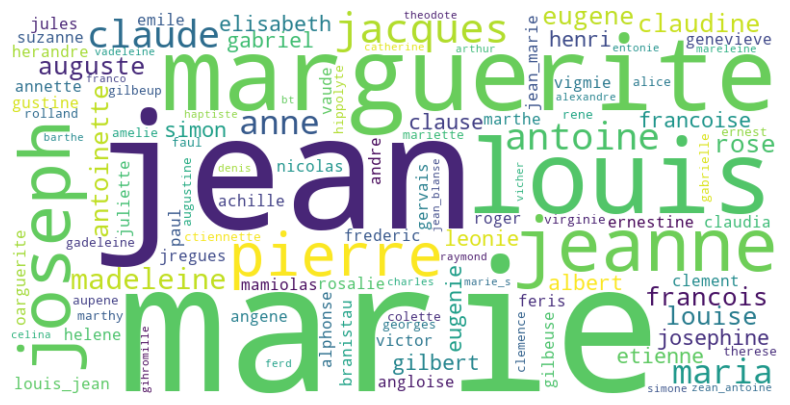

In [133]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Définir le texte à utiliser pour générer le nuage de mots
texte = "Python est un langage de programmation puissant et polyvalent. Il est largement utilisé dans le développement logiciel, l'analyse de données, l'apprentissage automatique et bien d'autres domaines."

# Créer l'objet WordCloud avec les paramètres souhaités
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(liste_prenoms)

# Afficher le nuage de mots
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()
wordcloud.to_file('wordcloud.png')



In [134]:
Final_input.head(1)

,Phrase,prenom,input_ids
0,"nom:chardon, ,prenom:marie , ,date_naissance:3...",marie,"[tensor(101), tensor(2053), tensor(2213), tens..."


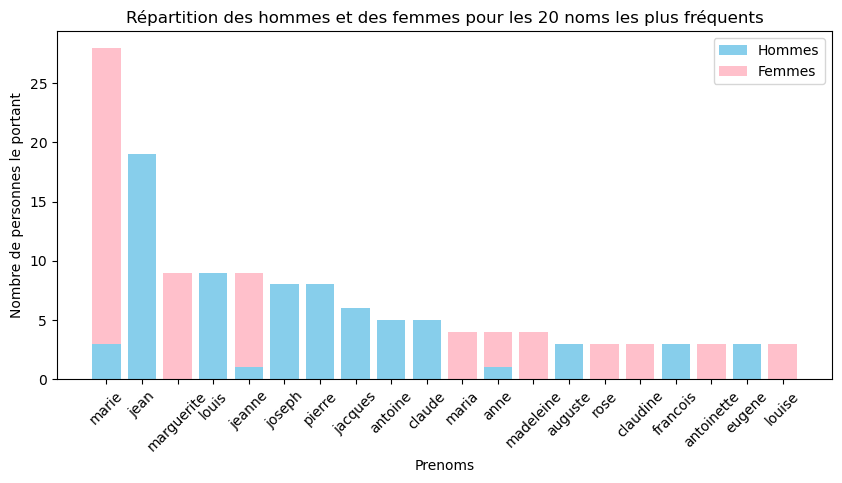

In [136]:
from collections import Counter

# Liste de chaînes de caractères
liste_chaines = list(Prenoms)

# Compter les occurrences de chaque chaîne
occurrences = Counter(liste_chaines)

# Obtenir les 10 chaînes les plus présentes
top_10_chaines = occurrences.most_common(20)

# Extraire les chaînes et leurs occurrences
noms = [chaine for chaine, occurrence in top_10_chaines]
occurrences_total = [occurrence for chaine, occurrence in top_10_chaines]

X=list(Final_input.prenom.values)
Y=list(df_w['labels'].values)
data = {'Prenom': X,
        'Sexe': Y}
df = pd.DataFrame(data)

# Calculer la répartition des hommes et des femmes pour chaque nom
repartition_hommes = []
repartition_femmes = []
for nom in noms:
    # Filtrer le DataFrame par nom
    df_nom = df[df['Prenom'] == nom]
    # Compter les occurrences de chaque sexe pour ce nom
    occurences_hommes = len(df_nom[df_nom['Sexe'] == 1])
    occurences_femmes = len(df_nom[df_nom['Sexe'] == 0])
    # Ajouter les proportions à la liste
    repartition_hommes.append(occurences_hommes)
    repartition_femmes.append(occurences_femmes)

# Tracer le graphique
plt.figure(figsize=(10, 6))

# Tracer les barres pour les hommes
plt.bar(noms, repartition_hommes, color='skyblue', label='Hommes')

# Tracer les barres pour les femmes
plt.bar(noms, repartition_femmes, bottom=repartition_hommes, color='pink', label='Femmes')

plt.xlabel('Prenoms')
plt.ylabel('Nombre de personnes le portant')
plt.title('Répartition des hommes et des femmes pour les 20 noms les plus fréquents')
plt.xticks(rotation=45)  # Rotation des étiquettes sur l'axe des x pour une meilleure lisibilité
plt.legend()  # Afficher la légende
plt.subplots_adjust(bottom=0.3)
plt.savefig('plotPrenom.png')

plt.show()

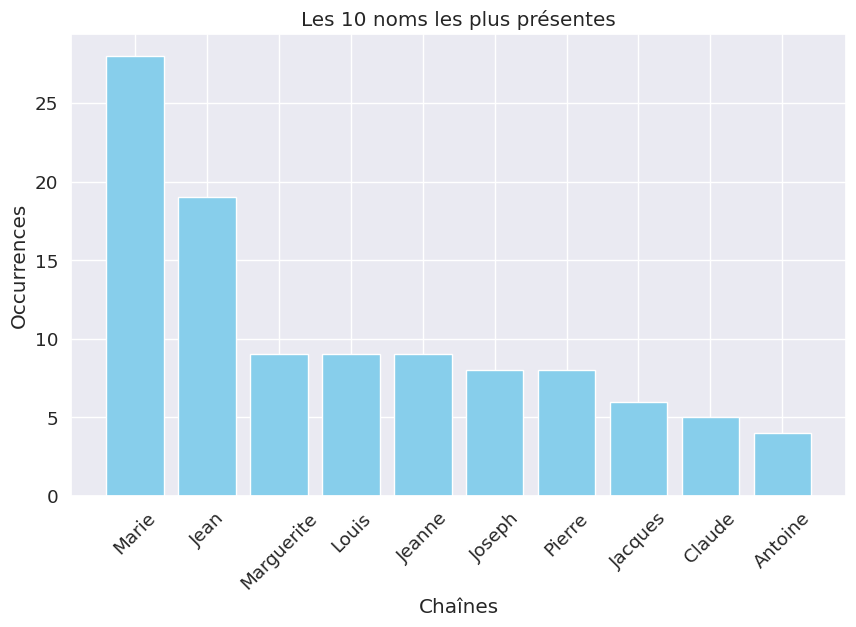

In [1385]:
from collections import Counter
import matplotlib.pyplot as plt

# Liste de chaînes de caractères
liste_chaines = list(Prenoms)

# Compter les occurrences de chaque chaîne
occurrences = Counter(liste_chaines)

# Obtenir les 10 chaînes les plus présentes
top_10_chaines = occurrences.most_common(10)

# Extraire les chaînes et leurs occurrences
chaines = [chaine for chaine, occurrence in top_10_chaines]
occurrences = [occurrence for chaine, occurrence in top_10_chaines]

# Tracer le graphique
plt.figure(figsize=(10, 6))
plt.bar(chaines, occurrences, color='skyblue')
plt.xlabel('Chaînes')
plt.ylabel('Occurrences')
plt.title('Les 10 noms les plus présentes')
plt.xticks(rotation=45)  # Rotation des étiquettes sur l'axe des x pour une meilleure lisibilité

# Enregistrer le plot sous forme d'image PNG
plt.savefig('plot1.png')

# Afficher le graphique
plt.show()





In [137]:
[Final_input.input_ids[i].size(0) for i in range(Final_input.shape[0])][1:10]

[78, 78, 78, 78, 78, 78, 78, 78, 78]

In [1387]:
Final_input.columns

Index(['Phrase', 'prenom', 'input_ids'], dtype='object')

In [1388]:
Final_input.columns

Index(['Phrase', 'prenom', 'input_ids'], dtype='object')

In [138]:
Final_input["labels"]=df_w['labels'].values

In [139]:
Final_input=Final_input.drop(["Phrase"],axis=1)
Final_input.head(3)

,prenom,input_ids,labels
0,marie,"[tensor(101), tensor(2053), tensor(2213), tens...",0
1,louis jean,"[tensor(101), tensor(2053), tensor(2213), tens...",1
2,marie,"[tensor(101), tensor(2053), tensor(2213), tens...",0


In [1391]:
#Final_input["Probas"]=Probas[:]
#Final_input.head(2)

In [140]:
Final_input=Final_input.set_index("prenom")

In [141]:
Final_input.head(3)

,input_ids,labels
prenom,,
marie,"[tensor(101), tensor(2053), tensor(2213), tens...",0
louis jean,"[tensor(101), tensor(2053), tensor(2213), tens...",1
marie,"[tensor(101), tensor(2053), tensor(2213), tens...",0


In [142]:
from sklearn.model_selection import train_test_split
Train_data,Test_data=train_test_split(Final_input,test_size=0.2)
X_train,Y_train=Train_data.input_ids,Train_data.labels
X_test,Y_test=Test_data.input_ids,Test_data.labels
print( " Train :", X_train.shape,Y_train.shape)
print( " Test :", X_test.shape,Y_test.shape)
# Transormer les dafaframes en listes 
X_train[0]

 Train : (192,) (192,)
 Test : (49,) (49,)


tensor([  101,  2053,  2213,  1024, 25830,  1010,  1010,  3653,  3630,  2213,
         1024, 16821,  1010,  1010,  3058,  1035,  6583, 21205,  5897,  1024,
         7005,  1010,  1010, 22470,  2595,  1035,  6583, 21205,  5897,  1024,
         2522, 18845, 15465,  1010,  1010,  7189,  1024, 10026,  1010,  1010,
         9518,  1024, 12731,  2140,  7903, 27870,  1010,  1010, 12666, 11236,
         1024,  9161,   999,  9713,  2487,   102,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0])

 #  5 Build Model 

In [144]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset  
import pandas as pd

# 5.1 : Model 1 : Dans ce modéle nous allons utiliser 4 couche de reseau dense

In [187]:
# 1. Charger les données depuis le DataFrame
# Exemple de données fictives

# Définir la seed pour PyTorch
torch.manual_seed(1996)
# Convertir les données en tenseurs PyTorch
tenseurs = torch.stack(Train_data['input_ids'].tolist())
labels = torch.tensor(Train_data['labels'].tolist())
input_len=78
# Définir l'architecture du réseau de neurones
class classe_model1(nn.Module):
    def __init__(self):
        super(classe_model1, self).__init__()
        self.couche_lineaire_1 = nn.Linear(input_len, 39)  # Couche linéaire avec 10 entrées et 50 sorties
        self.couche_lineaire_11 = nn.Linear(39, 20)  # Couche linéaire avec 10 entrées et 50 sorties
        self.couche_lineaire_12 = nn.Linear(20, 10)  # Couche linéaire avec 10 entrées et 50 sorties

        self.couche_lineaire_2 = nn.Linear(10, 2)   # Couche linéaire avec 50 entrées et 2 sorties (2 classes)

    def forward(self, x):
        x = torch.relu(self.couche_lineaire_1(x.float()))  # Convertir les tenseurs d'entrée en type torch.float
        x = self.couche_lineaire_11(x)
        x = self.couche_lineaire_12(x)

        x = self.couche_lineaire_2(x)             # Pas de fonction d'activation pour la dernière couche
        return x

# Créer un DataLoader pour les données d'entraînement
dataset = TensorDataset(tenseurs, labels)
train_loader = DataLoader(dataset, batch_size=10, shuffle=True)

# Initialiser le modèle
model1 = classe_model1()

# Définir la fonction de perte et l'optimiseur
criterion = nn.CrossEntropyLoss()  # Fonction de perte pour les problèmes de classification
optimizer = optim.Adam(model1.parameters(), lr=0.001)  # Optimiseur Adam avec un taux d'apprentissage de 0.001

num_epochs=2000
# Entraîner le modèle
# Variables pour le calcul de l'exactitude
total_correct = 0
total_samples = 0

# Initialiser l'exactitude précédente à zéro
prev_accuracy = 0.0

# Entraîner le modèle
for epoch in range(num_epochs):
    for batch_tenseurs, batch_labels in train_loader:
        optimizer.zero_grad()
        predictions = model1(batch_tenseurs)
        loss = criterion(predictions, batch_labels)
        loss.backward()
        optimizer.step()

        # Calculer les prédictions correctes
        _, predicted = torch.max(predictions, 1)
        total_correct += (predicted == batch_labels).sum().item()
        total_samples += batch_labels.size(0)

    # Calculer l'exactitude à la fin de chaque époque
    accuracy = total_correct / total_samples
    #print(f'Epoch [{epoch+1}/{num_epochs}], Accuracy: {accuracy}')

    # Vérifier si l'exactitude diminue
    if accuracy < prev_accuracy:
        print("Accuracy decreased. Stopping training.")
        print(f'Epoch [{epoch+1}/{num_epochs}], Accuracy: {prev_accuracy}')

        break
    elif epoch+1==num_epochs:
        print(f'Epoch [{epoch+1}/{num_epochs}], Accuracy: {accuracy}')
    
    # Mettre à jour l'exactitude précédente
    prev_accuracy = accuracy
    #performance1=pd.DataFrame({'Model_name':"model1","data":"Train","Accuracy":prev_accuracy})
    performance1=pd.DataFrame(["model1","Train",prev_accuracy])

    performance1



Accuracy decreased. Stopping training.
Epoch [70/2000], Accuracy: 0.9029287439613527


In [ ]:
# Model2 : Nous allons utiliser 3 couche de reseaux denses

In [190]:
performance1=pd.DataFrame(performance1.values.transpose())

In [191]:
performance1

,0,1,2
0,model1,Train,0.902929


In [199]:
performance_data=pd.merge(performance1,performance2,how="outer")

In [203]:
performance_data=performance_data.set_index(performance_data.columns[0])

In [204]:
performance_data.columns=["Dataset","Accuracy"]

In [206]:
performance_data["Nbr_of_dense_layer_used"]=[4,3]

In [208]:
performance_data.to_csv("performance_data.csv")

In [211]:
# 1. Charger les données depuis le DataFrame
# Exemple de données fictives

# Définir la seed pour PyTorch
torch.manual_seed(1996)
# Convertir les données en tenseurs PyTorch
tenseurs = torch.stack(Train_data['input_ids'].tolist())
labels = torch.tensor(Train_data['labels'].tolist())
input_len=78
# Définir l'architecture du réseau de neurones
class Classe_model2(nn.Module):
    def __init__(self):
        super(Classe_model2, self).__init__()
        self.couche_lineaire_1 = nn.Linear(input_len, 39)  # Couche linéaire avec 10 entrées et 50 sorties
        self.couche_lineaire_11 = nn.Linear(39, 10)  # Couche linéaire avec 10 entrées et 50 sorties

        self.couche_lineaire_2 = nn.Linear(10, 2)   # Couche linéaire avec 50 entrées et 2 sorties (2 classes)

    def forward(self, x):
        x = torch.relu(self.couche_lineaire_1(x.float()))  # Convertir les tenseurs d'entrée en type torch.float
        x = self.couche_lineaire_11(x)

        x = self.couche_lineaire_2(x)             # Pas de fonction d'activation pour la dernière couche
        return x

# Créer un DataLoader pour les données d'entraînement
dataset = TensorDataset(tenseurs, labels)
train_loader = DataLoader(dataset, batch_size=10, shuffle=True)

# Initialiser le modèle
model2 = Classe_model2()

# Définir la fonction de perte et l'optimiseur
criterion = nn.CrossEntropyLoss()  # Fonction de perte pour les problèmes de classification
optimizer = optim.Adam(model2.parameters(), lr=0.001)  # Optimiseur Adam avec un taux d'apprentissage de 0.001

num_epochs=2000
# Entraîner le modèle
# Variables pour le calcul de l'exactitude
total_correct = 0
total_samples = 0

# Initialiser l'exactitude précédente à zéro
prev_accuracy = 0.0

# Entraîner le modèle
for epoch in range(num_epochs):
    for batch_tenseurs, batch_labels in train_loader:
        optimizer.zero_grad()
        predictions = model2(batch_tenseurs)
        loss = criterion(predictions, batch_labels)
        loss.backward()
        optimizer.step()

        # Calculer les prédictions correctes
        _, predicted = torch.max(predictions, 1)
        total_correct += (predicted == batch_labels).sum().item()
        total_samples += batch_labels.size(0)

    # Calculer l'exactitude à la fin de chaque époque
    accuracy = total_correct / total_samples
    #print(f'Epoch [{epoch+1}/{num_epochs}], Accuracy: {accuracy}')

    # Vérifier si l'exactitude diminue
    if accuracy < prev_accuracy:
        print("Accuracy decreased. Stopping training.")
        print(f'Epoch [{epoch+1}/{num_epochs}], Accuracy: {prev_accuracy}')

        break
    elif epoch+1==num_epochs:
        print(f'Epoch [{epoch+1}/{num_epochs}], Accuracy: {accuracy}')
    
    # Mettre à jour l'exactitude précédente
    prev_accuracy = accuracy
    performance2=pd.DataFrame(["model2","Train",prev_accuracy])

    performance2



Accuracy decreased. Stopping training.
Epoch [18/2000], Accuracy: 0.758578431372549


In [195]:
#performance2=pd.DataFrame(performance2.values.transpose())
performance2.to_csv("performance2.csv")

In [212]:
def predictor(Test_data,model=reseau):
# Charger vos nouvelles données dans un tenseur PyTorch (par exemple, Test_data)
# Assume que Test_data est votre DataFrame contenant les nouvelles données

# Convertir les données en tenseurs PyTorch
       tenseurs_test = torch.stack(Test_data['input_ids'].tolist())
       labels_array=Test_data.labels.values

# Passer les tenseurs de données à travers votre modèle pour obtenir les prédictions
       with torch.no_grad():
        predictions = model(tenseurs_test)

# Obtenir les prédictions et les valeurs réelles sous forme de listes ou tableaux NumPy
       predictions_array = predictions.argmax(dim=1).numpy()
       labels_array = Test_data['labels'].values

# Créer un DataFrame pandas à partir des listes ou tableaux NumPy
       results_df = pd.DataFrame({'valeurs_prédites': predictions_array, 'valeurs_réelles': labels_array})

# Retourner le DataFrame avec les résultats
       return results_df
    

In [213]:

results_2=predictor(Test_data,model=model2)
results_2.head(2)

,valeurs_prédites,valeurs_réelles
0,1,0
1,0,0


In [150]:
def get_accuracy(results_df):
    total_samples=results_df.shape[0]
    total_correct=0
    labels_true=results_df.valeurs_réelles
    labels_pred=results_df.valeurs_prédites

    total_correct += (labels_true==labels_pred).sum()
    accuracy= total_correct / total_samples


    # Calculer l'exactitude à la fin de chaque époque
    return accuracy 

In [151]:
get_accuracy(results_df)

0.5918367346938775

In [209]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
def plot_confug_matrix(results_df):
        labels_true=results_df.valeurs_réelles
        labels_pred=results_df.valeurs_prédites
    # Calculer la matrice de confusion
        conf_matrix = confusion_matrix(labels_true, labels_pred)
        class_names = ['Classe 0', 'Classe 1']
        plt.figure(figsize=(8, 6))
        sns.set(font_scale=1.2)  # Ajuster la taille de la police
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, annot_kws={"size": 14}, xticklabels=class_names, yticklabels=class_names)
        plt.xlabel('Classe prédite')
        plt.ylabel('Classe réelle')
        plt.title('Matrice de confusion')
        plt.savefig('Matrice_de_confusion.png')

        plt.show()


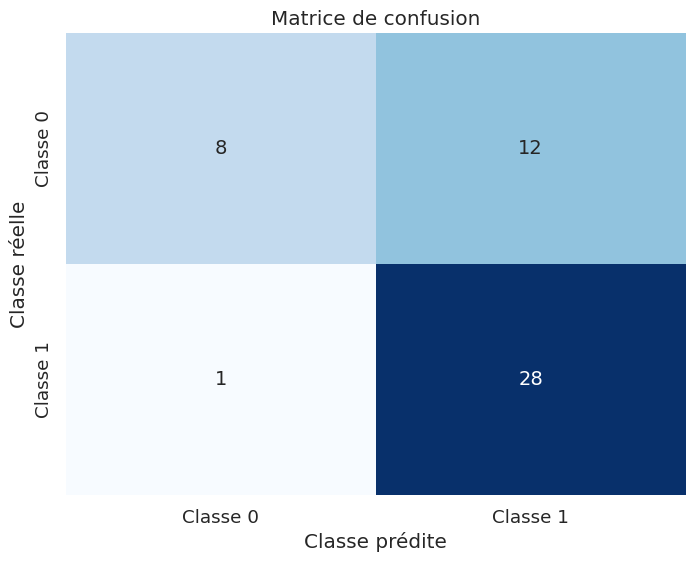

In [214]:
plot_confug_matrix(results_2)

In [161]:
Final_input.columns

Index(['input_ids', 'labels'], dtype='object')

# FIN DU PROJET

# AUTRE PISTES

In [1170]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import numpy as np

# Définir la seed pour PyTorch
torch.manual_seed(1996)
# Définir une fonction pour ajuster les étiquettes en fonction des noms

def adjust_labels(names):
    adjusted_labels = []
    for name in names:
        # Déterminer le paramètre Bernoulli en fonction du nom
        #param = hash(name) % 10 / 10  # Par exemple, utiliser le hachage du nom modulo 10 pour obtenir un paramètre entre 0 et 1
        # Générer un échantillon Bernoulli en fonction du paramètre
        param=Final_input.loc[name,"Probas"]
        label = np.random.binomial(1, param)
        # Ajouter l'étiquette ajustée à la liste
        adjusted_labels.append(label)
    return torch.tensor(adjusted_labels)

# 1. Charger les données depuis le DataFrame
# Exemple de données fictives
# Assuming df2 is your DataFrame

# Convertir les données en tenseurs PyTorch
tenseurs = torch.stack(Final_input['input_ids'].tolist()[1:])
labels = torch.tensor(Final_input['labels'].tolist()[1:])
input_len = 78

# Créer une liste de noms associés à chaque entrée (assumant que names est une liste associée à votre DataFrame)
prenoms=list(Final_input["Prénom"].values)
#names = [prenoms[i] + str(i) for i in range(len(tenseurs))]
names=Final_input["Prénom"].values


# 2. Définir l'architecture du réseau de neurones
class ReseauDeNeurones(nn.Module):
    def __init__(self):
        super(ReseauDeNeurones, self).__init__()
        self.couche_lineaire_1 = nn.Linear(input_len, 50)  # Couche linéaire avec 10 entrées et 50 sorties
        self.couche_lineaire_2 = nn.Linear(50, 2)   # Couche linéaire avec 50 entrées et 2 sorties (2 classes)

    def forward(self, x):
        x = torch.relu(self.couche_lineaire_1(x.float()))  # Convertir les tenseurs d'entrée en type torch.float
        x = self.couche_lineaire_2(x)             # Pas de fonction d'activation pour la dernière couche
        return x

# Créer un DataLoader pour les données d'entraînement
dataset = TensorDataset(tenseurs, labels)
train_loader = DataLoader(dataset, batch_size=10, shuffle=True)

# Initialiser le modèle
reseau = ReseauDeNeurones()

# Définir la fonction de perte et l'optimiseur
criterion = nn.CrossEntropyLoss()  # Fonction de perte pour les problèmes de classification
optimizer = optim.Adam(reseau.parameters(), lr=0.001)  # Optimiseur Adam avec un taux d'apprentissage de 0.001

num_epochs = 2000
# Entraîner le modèle
# Variables pour le calcul de l'exactitude
total_samples = len(labels)

# Entraîner le modèle
for epoch in range(num_epochs):
    total_correct = 0
    for batch_tenseurs, batch_labels in train_loader:
        optimizer.zero_grad()
        predictions = reseau(batch_tenseurs)
        # Ajuster les étiquettes en fonction des noms
        adjusted_labels = adjust_labels(names)
        loss = criterion(predictions, adjusted_labels)
        loss.backward()
        optimizer.step()

        # Calculer les prédictions correctes
        _, predicted = torch.max(predictions, 1)
        total_correct += (predicted == adjusted_labels).sum().item()

    # Calculer l'exactitude à la fin de chaque époque
    accuracy = total_correct / total_samples

    # Vérifier si l'exactitude diminue
    if accuracy < prev_accuracy:
        print("Accuracy decreased. Stopping training.")
        print(f'Epoch [{epoch+1}/{num_epochs}], Accuracy: {prev_accuracy}')

        break
    elif epoch + 1 == num_epochs:
        print(f'Epoch [{epoch+1}/{num_epochs}], Accuracy: {accuracy}')

    # Mettre à jour l'exactitude précédente
    prev_accuracy = accuracy


KeyError: 'Prénom'

In [ ]:
X=Final_input["input_ids"].apply(lambda x :list(x.numpy()))
X=list(X)


In [ ]:
X=np.array(X)

In [ ]:
X.shape

In [ ]:
y=Final_input.labels.values
y.shape

In [ ]:
# Importer les bibliothèques nécessaires
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix

# Générer des données d'exemple

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialiser le modèle de classification (par exemple, régression logistique)
model = LogisticRegression()

# Entraîner le modèle sur les données d'entraînement
model.fit(X_train, y_train)

# Faire des prédictions sur l'ensemble de test
y_pred = model.predict(X_test)

# Calculer l'exactitude du modèle
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Afficher la matrice de confusion
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)
